In [74]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras .models import Sequential
from tensorflow.keras .layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras .optimizers import SGD
import math
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
#!pip install tensorflow

In [104]:
# Some functions to help out with
def plot_predictions(df_plot):
    plt.figure(figsize=(18,6))
    plt.plot(df_plot,label=['Actual Consumption','Predicted Consumption'])
    plt.title('Electricity Consumption Prediction')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh/hh)')
    plt.legend()
    plt.show()

def return_mape(test,predicted):
    mape = mean_absolute_percentage_error(test, predicted)
    print("The  mean absolute percenatge error is {}.".format(mape))

In [ ]:
dataset = pd.read_csv('https://storage.googleapis.com/energy_consumption_903/df_all_avg_v1.csv', index_col='DateTime', parse_dates=['DateTime'])
dataset.head()

In [24]:
df=dataset.groupby(by=dataset.index).mean()
#df.reset_index(inplace=True)
df

,KWH/hh
DateTime,
2012-01-01 00:00:00,0.231551
2012-01-01 00:30:00,0.249021
2012-01-01 01:00:00,0.230137
2012-01-01 01:30:00,0.222626
2012-01-01 02:00:00,0.228136
...,...
2014-02-27 22:00:00,0.343924
2014-02-27 22:30:00,0.335663
2014-02-27 23:00:00,0.269226


In [27]:

# Checking for missing values
training_set = df[:'2013'].loc[:,['KWH/hh']].values
test_set = df['2014':].loc[:,['KWH/hh']].values
training_set

array([[0.23155088],
       [0.24902058],
       [0.2301375 ],
       ...,
       [0.32711394],
       [0.2759965 ],
       [0.28107269]])

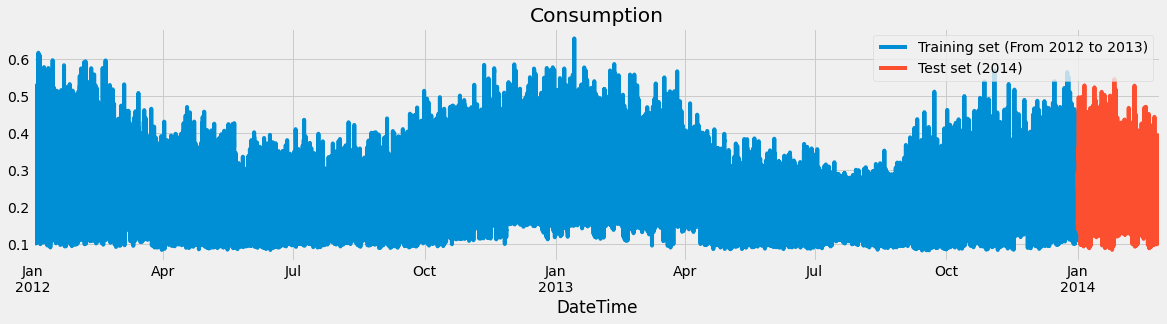

In [61]:
df["KWH/hh"][:'2013'].plot(figsize=(18,4),legend=True)
df["KWH/hh"]['2014':].plot(figsize=(18,4),legend=True)
plt.legend(['Training set (From 2012 to 2013)','Test set (2014)'])
plt.title('Consumption')
plt.show()

In [28]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [29]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [30]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [31]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='MeanAbsolutePercentageError')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 19s 131ms/step - loss: 0.0384
Epoch 2/50
85/85 [==============================] - 12s 145ms/step - loss: 0.0187
Epoch 3/50
85/85 [==============================] - 10s 121ms/step - loss: 0.0168
Epoch 4/50
85/85 [==============================] - 9s 100ms/step - loss: 0.0145
Epoch 5/50
85/85 [==============================] - 10s 113ms/step - loss: 0.0127
Epoch 6/50
85/85 [==============================] - 9s 107ms/step - loss: 0.0121
Epoch 7/50
85/85 [==============================] - 9s 105ms/step - loss: 0.0111
Epoch 8/50
85/85 [==============================] - 12s 136ms/step - loss: 0.0108
Epoch 9/50
85/85 [==============================] - 9s 105ms/step - loss: 0.0103
Epoch 10/50
85/85 [==============================] - 9s 106ms/step - loss: 0.0101
Epoch 11/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0097
Epoch 12/50
85/85 [==============================] - 9s 108ms/step - loss: 0.0096
Epoch 13/50
85/85 [

In [49]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entries of test set have 60 previous values which is impossible to get 

dataset_total = pd.concat((df["KWH/hh"][:'2013'],df["KWH/hh"]['2014':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [50]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,2845):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_consumption = regressor.predict(X_test)
predicted_consumption = sc.inverse_transform(predicted_consumption)

88/88 [==============================] - 3s 37ms/step


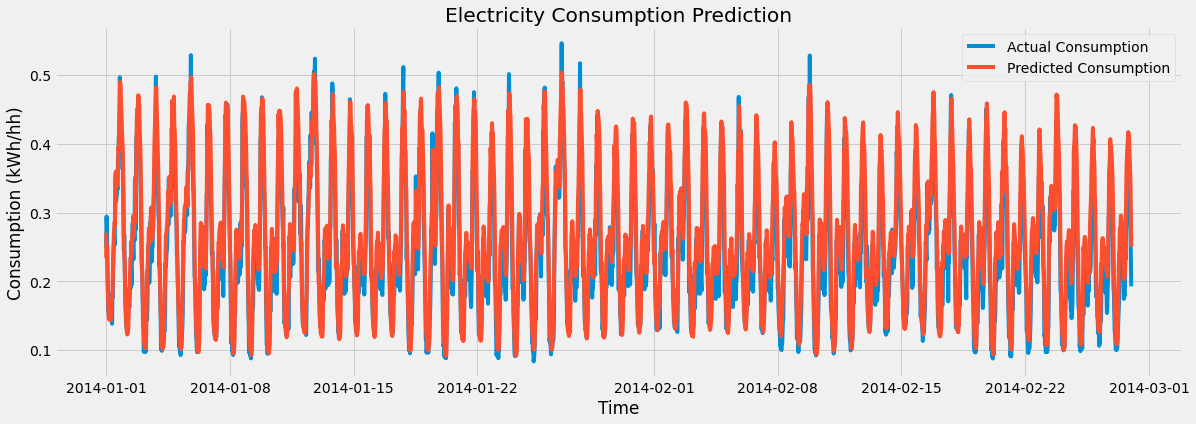

The  mean absolute percenatge error is 0.12946243633495746.


In [105]:
# Visualizing the results for LSTM
df_plot=df['2014':].copy()
df_plot.rename(columns={'KWH/hh':'Test'},inplace=True)
df_plot['Predicted']=predicted_consumption
plot_predictions(df_plot)
# Evaluating our model
return_mape(test_set,predicted_consumption)